In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# ## Plotly plotting support
# import plotly.plotly as py

import plotly.offline as py
py.init_notebook_mode(connected=False)

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

ModuleNotFoundError: No module named 'plotly'

# Introduction

In this lecture we examine the process of data cleaning and Exploratory Data Analysis (EDA).  Often you will acquire or even be given a collection of data in order to conduct some analysis or answer some questions. The first step in using that data is to ensure that it is in the correct form (cleaned) and that you understand its properties and limitations (EDA).  Often as you explore data through EDA you will identify additional transformations that may be required before the data is ready for analysis.

In this notebook we obtain crime data from the city of Berkeley's public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data. 

 Getting the Data

To begin this analysis we want to get data about crimes in Berkeley.  Remarkably, the city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining the:

1. [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5)
1. [Stop Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data/6e9j-pj9p)

Fortunately, this data is also relatively well document with detailed descriptions of what it contains.  Here are summaries of the fields in the data:

### Calls Data
<img src="calls_desc.png" width=800px />

### Stop Data
<img src="stops_desc.png" width=800px />




## Most data has bad documentation:

Unfortunately, data is seldom well documented and when it is you may not be able to trust the documentation. It is therefore critical that when we download the data we investigate the fields and verify that it reflects the assumptions made in the documentation.



## Reproducible Data Science

In the interest of **reproducible data science** we will download the data programatically.  We have defined some helper functions in the [utils.py](utils.py) file.  I can then reuse these helper functions in many different notebooks.

In [3]:
from utils import fetch_and_cache

In [4]:
help(fetch_and_cache)

Help on function fetch_and_cache in module utils:

fetch_and_cache(data_url, file, data_dir='data', force=False)
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded
    
    return: The pathlib.Path object representing the file.



I can actually look at the source code in the notebook.

In [5]:
fetch_and_cache??

Occasionally, you will want to modify code that you have imported.  To reimport those modifications you can either use the python importlib library:

```python
from importlib import reload
import utils;reload(utils);
```

or use IPython magic which will intelligently import code when files change:

```python
%load_ext autoreload
%autoreload 2
```

## Downloading the Data

Notice that because I record how I got the data in the notebook, others can reproduce this experiment.  However, it is worth noting that **the data can change**.  We will want to pay attention to file timestamps.

In [6]:
from importlib import reload
import utils;reload(utils);
from utils import fetch_and_cache

calls_file = fetch_and_cache("https://data.cityofberkeley.info/api/views/k2nh-s5h5/rows.csv?accessType=DOWNLOAD",
                "calls_for_service.csv", force=False)

[#########                                ]
Downloaded rows.csv?accessType=DOWNLOAD!
MD5 hash of file: beed508fd11d934a1d9cf5353f89f305


In [7]:
stops_file = fetch_and_cache("https://data.cityofberkeley.info/api/views/6e9j-pj9p/rows.json?accessType=DOWNLOAD",
                "stops.json", force=False)

[################################################################################################################################################]
Downloaded rows.json?accessType=DOWNLOAD!
MD5 hash of file: 1d4b10146845449411bc35d00367c2f0


To demonstrated live downloading (of something we won't need in lecture) we can download professor Gonzalez's website.  

In [8]:
gonzalez_file = fetch_and_cache("https://people.eecs.berkeley.edu/~jegonzal/assets/jegonzal.jpg", 
                                "gonzalez.jpg", 
                                force=True)

[##                                       ]
Downloaded jegonzal.jpg!
MD5 hash of file: ab428e2864152b70e28e58941b10f47d


# Exploring the data

Now that we have obtained the data we want to understand its:

* **Structure** -- the "shape" of a data file
* **Granularity** -- how fine/coarse is each datum
* **Scope** -- how (in)complete is the data
* **Temporality** -- how is the data situated in time
* **Faithfulness** -- how well does the data capture "reality"



## Structure

Before we even begin to load the data it often helps to understand a little about the high-level structure:

1. How much data do I have?
1. How is it formatted?

### How big is the data?

I often like to start my analysis by getting a rough estimate of the size of the data.  This will help inform the tools I use and how I view the data.  If it is relatively small I might use a text editor or a spreadsheet to look at the data.  If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

In [9]:
type(stops_file)

pathlib.PosixPath

In [10]:
help(stops_file)

Help on PosixPath in module pathlib object:

class PosixPath(Path, PurePosixPath)
 |  Path subclass for non-Windows systems.
 |  
 |  On a POSIX system, instantiating a Path should return this object.
 |  
 |  Method resolution order:
 |      PosixPath
 |      Path
 |      PurePosixPath
 |      PurePath
 |      builtins.object
 |  
 |  Methods inherited from Path:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, t, v, tb)
 |  
 |  absolute(self)
 |      Return an absolute version of this path.  This function works
 |      even if the path doesn't point to anything.
 |      
 |      No normalization is done, i.e. all '.' and '..' will be kept along.
 |      Use resolve() to get the canonical path to a file.
 |  
 |  chmod(self, mode)
 |      Change the permissions of the path, like os.chmod().
 |  
 |  exists(self)
 |      Whether this path exists.
 |  
 |  expanduser(self)
 |      Return a new path with expanded ~ and ~user constructs
 |      (as returned by os.path.expanduser)
 |  
 |

In [11]:
stops_file.stat()

os.stat_result(st_mode=33188, st_ino=293192338, st_dev=16777224, st_nlink=1, st_uid=507, st_gid=20, st_size=9168085, st_atime=1536283336, st_mtime=1536281354, st_ctime=1536281354)

In [12]:
calls_file.stat().st_size

687611

All the files are relatively small and we could comfortable examine them in a text editors.  (Personally, I like *Visual Studio Code* or *emacs* but others may have a different *vi*ew.). 

In listing the files I noticed that the names suggest that they are all text file formats:
* **CSV**: Comma separated values is a very standard table format.
* **JSON**: JavaScript Object Notation is a very standard semi-structured file format used to store nested data.

We will dive into the formats in a moment.  However because these are text data I might also want to investigate the number of lines which often correspond to records.

In [13]:
from utils import line_count
help(line_count)

Help on function line_count in module utils:

line_count(file)
    Computes the number of lines in a file.
    
    file: the file in which to count the lines.
    return: The number of lines in the file



In [14]:
print("Lines in the calls file", line_count(calls_file))

Lines in the calls file 11343


In [15]:
print("Lines in the stops file", line_count(stops_file))

Lines in the stops file 42999


If your IPython session is running on a [POSIX](https://en.wikipedia.org/wiki/POSIX) compliant machine (e.g., mac/linux) you could also run:

```bash
!wc data/*
```

which would produce (lines, words, characters):

```
   16053   85512  976004 data/calls_for_service.csv
     148    1541   54988 data/gonzalez.jpg
   29850  658525 6123225 data/stops.json
   46051  745578 7154217 total
```

In [16]:
!wc data/*

   11343   59935  687611 data/calls_for_service.csv
     148    1541   54988 data/gonzalez.jpg
   42998  972624 9168085 data/stops.json
   54489 1034100 9910684 total


If we wanted to learn more about the command we could use the `man` (short for **manual**) command to read the manual page for `wc` (word count).

#### Additional File Meta-Data

Meta-data is data about the data.  Most filesystems will maintain information about when a file was created, read, or modified.  Below we use the Python `time` library to print the time in the local representation.  Note, time is often measured in [Unix Time](https://en.wikipedia.org/wiki/Unix_time) (time in second since January 1st, 1970).


In [17]:
import time 
print("Time of creation (seconds since Epoch):", 
      stops_file.stat().st_ctime)
print("Local time of creation:", 
      time.ctime(stops_file.stat().st_ctime))

Time of creation (seconds since Epoch): 1536281354.0
Local time of creation: Thu Sep  6 17:49:14 2018



### What is the file format?  (Can we trust extensions?)

We already noticed that the files end in `csv` and `json` which suggests that these are comma separated and javascript object files respectively.  However, we can't always rely on the naming as this is only a convention.  For example, here we picked the name of the file when downloading based on some hints in the URL.



**Often files will have incorrect extensions or no extension at all.**

Let's assume that these are text files (and do not contain binary encoded data) so we can print a "few lines" to get a better understanding of the file.

In [18]:
from utils import head
help(head)

Help on function head in module utils:

head(filename, lines=5)
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.



In [19]:
head(calls_file)

['CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State\n',
 '18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\n',
 'Berkeley, CA\n',
 '(37.856572, -122.275241)",OREGON STREET & MCGEE AVE,Berkeley,CA\n',
 '18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\n']

**Note:** Because the `gonzalez_file` is a JPEG (image) it is not a character file format and looking at the head of the file isn't going to work:

In [20]:
head(stops_file)

['{\n',
 '  "meta" : {\n',
 '    "view" : {\n',
 '      "id" : "6e9j-pj9p",\n',
 '      "name" : "Berkeley PD - Stop Data",\n']

In [21]:
#head(gonzalez_file)

### What are some observations about `Calls` data?

1. It appears to be in comma separated value (CSV) format.
1. First line contains the column headings.
1. There are lots of **new-line** `\n` characters:
    * at the ends of lines (delimiting records?)
    * *within records* as part of addresses.
1. There are **"quoted"** strings in the `Block_Location` column:
```
"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)"
```
these are going to be difficult.  What are the implications on our earlier line count calculations?

In [22]:
head(calls_file)

['CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State\n',
 '18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\n',
 'Berkeley, CA\n',
 '(37.856572, -122.275241)",OREGON STREET & MCGEE AVE,Berkeley,CA\n',
 '18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\n']

### What are some observations about `Stops` data?

This appears to be a fairly standard JSON file.  We notice that the file appears to contain a description of itself in a field called "meta" (which is presumably short for meta-data).  We will come back to this meta data in a moment but first let's quickly discuss the JSON file format.


In [23]:
head(stops_file, lines=20)

['{\n',
 '  "meta" : {\n',
 '    "view" : {\n',
 '      "id" : "6e9j-pj9p",\n',
 '      "name" : "Berkeley PD - Stop Data",\n',
 '      "attribution" : "Berkeley Police Department",\n',
 '      "averageRating" : 0,\n',
 '      "category" : "Public Safety",\n',
 '      "createdAt" : 1444171604,\n',
 '      "description" : "This data was extracted from the Department’s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.\\r\\n\\r\\nAddress data has been changed from a specific addres


### A quick note on JSON

[JSON (JavaScript Object Notation)](http://www.json.org) is a common format for exchanging complex structured and semi-structured data. 

```javascript
{
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": true, "a null value": null}
}
```

A few key points:
* JSON is a recursive format in that JSON fields can also contain JSON objects
* JSON closely matches Python Dictionaries:
```python
d = {
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": True, "a null value": None}
}
print(d['myfield3'])
```
* Very common in web technologies (... JavaScript)
* Many languages have tools for loading and saving JSON objects




## Loading the Data

We will now attempt to load the data into python.  We will be using the Pandas dataframe library for basic tabular data analysis.  Fortunately, the Pandas library has some relatively sophisticated functions for loading data. 


### Loading the Calls Data

Because the file appears to be a relatively well formatted CSV we will attempt to load it directly and allow the Pandas Library to deduce column headers.  (Always check that first row and column look correct after loading.)

In [24]:
calls = pd.read_csv(calls_file, warn_bad_lines=True)
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State  
0     OREGON STREET & MCGEE AVE  Berkeley    CA  
1            200 UNIVERSITY AVE  Berkeley    CA  
2                2200 MILVIA ST  Berkeley    CA  
3                 1200 SIXTH ST  Berkeley    CA  
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA

How many records did we get?

In [25]:
calls.size

41668

### Preliminary observations on the data?

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Appears to be some encoding of the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.


### Checking that the City and State fields are redundant

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [26]:
calls.groupby(["City", "State"]).count()

CASENO  OFFENSE  EVENTDT  EVENTTM  CVLEGEND  CVDOW  InDbDate  \
City     State                                                                 
Berkeley CA       3788     3788     3788     3788      3788   3788      3788   

                Block_Location  BLKADDR  
City     State                           
Berkeley CA               3788     3766

### Decoding day of the week

According to the documentation `CVDOW=0` is Sunday, `CVDOW=1` is Monday, ...,  Therefore we can make a series to decode the day of the week for each record and join that series with the calls data.

In [27]:
dow = pd.Series(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], name="DoW")
dow

0       Sunday
1       Monday
2      Tuesday
3    Wednesday
4     Thursday
5       Friday
6     Saturday
Name: DoW, dtype: object

In [28]:
calls['Day'] = dow[calls['CVDOW']].reset_index(drop=True)
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State        Day  
0     OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  
1            200 UNIVERSITY AVE  Berkeley    CA  Wednesday  
2                2200 MILVIA ST  Berkeley    CA     Friday  
3                 1200 SIXTH ST  Berkeley    CA    Tuesday  
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA   Saturday

We can also accomplish the same task using a join.

In [29]:
df_dow = pd.DataFrame(dow)
pd.merge(calls, df_dow, left_on='CVDOW', right_index=True).head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0   18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1   18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
6   18090660            IDENTITY THEFT  04/04/2018 12:00:00 AM   14:00   
7   18091024  THEFT MISD. (UNDER $950)  06/27/2018 12:00:00 AM   13:40   
12  18020810      ASSAULT/BATTERY FEL.  04/11/2018 12:00:00 AM   13:40   

              CVLEGEND  CVDOW                InDbDate  \
0   DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1              LARCENY      3  09/06/2018 03:30:13 AM   
6                FRAUD      3  09/06/2018 03:30:12 AM   
7              LARCENY      3  09/06/2018 03:30:13 AM   
12             ASSAULT      3  09/06/2018 03:30:12 AM   

                                       Block_Location  \
0   OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1   200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
6   1000 EUCLID AVE\nBerkeley, CA\n(37.891594, -12...   
7   1500 HARMON ST\nBerkeley, CA\n(37.848812, -122...   
12  2900 COLLEGE AVE\nBerkeley, CA\n(37.858356, -1...   

                      BLKADDR      City State        Day        DoW  
0   OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  Wednesday  
1          200 UNIVERSITY AVE  Berkeley    CA  Wednesday  Wednesday  
6             1000 EUCLID AVE  Berkeley    CA  Wednesday  Wednesday  
7              1500 HARMON ST  Berkeley    CA  Wednesday  Wednesday  
12           2900 COLLEGE AVE  Berkeley    CA  Wednesday  Wednesday

### Cleaning Block Location

The block location contains the GPS coordinates and I would like to use these to analyze the location of each request.  Let's try to extract the GPS coordinates using regular expressions (we will cover regular expressions in future lectures):


In [30]:
calls['Block_Location'][0]

'OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(37.856572, -122.275241)'

In [31]:
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t") 
    # Extract Lat and Lon using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*.\d*)\)",expand=True)
)
calls_lat_lon.head(10)

Lat          Lon
0  37.856572  -122.275241
1  37.865511  -122.309967
2  37.868574  -122.270415
3  37.881142   -122.30191
4  37.870308   -122.26805
5  37.867176  -122.267802
6  37.891594  -122.264883
7  37.848812  -122.278043
8  37.879467  -122.261062
9  37.858433  -122.280183

Double check that all of the records have a latitude and longitude:

In [32]:
calls_lat_lon.isnull().sum()

Lat    159
Lon    159
dtype: int64

The following block of code joins the extracted Latitude and Longitude fields with the calls data.  Notice that we actually drop these fields before joining.  This is to enable repeated invocation of this cell even after the join has been completed. 

In [33]:
# Remove Lat and Lon if they already existed before (reproducible)
calls.drop(["Lat", "Lon"], axis=1, inplace=True, errors="ignore")
# Join in the the latitude and longitude data
calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
# calls[["Lat", "Lon"]] = calls_lat_lon
# calls.join(calls_lat_lon)
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State        Day        Lat  \
0     OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  37.856572   
1            200 UNIVERSITY AVE  Berkeley    CA  Wednesday  37.865511   
2                2200 MILVIA ST  Berkeley    CA     Friday  37.868574   
3                 1200 SIXTH ST  Berkeley    CA    Tuesday  37.881142   
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA   Saturday  37.870308   

           Lon  
0  -122.275241  
1  -122.309967  
2  -122.270415  
3   -122.30191  
4   -122.26805

We can now look at a few of the records that were missing latitude and longitude entries:

In [34]:
calls[calls['Lat'].isnull()].head()

CASENO          OFFENSE                 EVENTDT EVENTTM  \
68   18090996    BURGLARY AUTO  06/21/2018 12:00:00 AM   01:00   
70   18033644    FRAUD/FORGERY  06/07/2018 12:00:00 AM   08:00   
79   18014355  ALCOHOL OFFENSE  03/10/2018 12:00:00 AM   22:47   
111  18038130        VANDALISM  07/06/2018 12:00:00 AM   17:00   
112  18041987       GUN/WEAPON  07/26/2018 12:00:00 AM   02:32   

                 CVLEGEND  CVDOW                InDbDate  \
68     BURGLARY - VEHICLE      4  09/06/2018 03:30:13 AM   
70                  FRAUD      4  09/06/2018 03:30:13 AM   
79   LIQUOR LAW VIOLATION      6  09/06/2018 03:30:08 AM   
111             VANDALISM      5  09/06/2018 03:30:09 AM   
112       WEAPONS OFFENSE      4  09/06/2018 03:30:09 AM   

                                        Block_Location  \
68                     400 OAKVALE AVE\nBerkeley, CA\n   
70                        200 MENLO PL\nBerkeley, CA\n   
79   UNIVERSITY AVENUE &amp; M L KING JR WAY\nBerke...   
111                      3000 BOISE ST\nBerkeley, CA\n   
112     HEARST AVENUE &amp; SEVENTH ST\nBerkeley, CA\n   

                                 BLKADDR      City State       Day  Lat  Lon  
68                       400 OAKVALE AVE  Berkeley    CA  Thursday  NaN  NaN  
70                          200 MENLO PL  Berkeley    CA  Thursday  NaN  NaN  
79   UNIVERSITY AVENUE & M L KING JR WAY  Berkeley    CA  Saturday  NaN  NaN  
111                        3000 BOISE ST  Berkeley    CA    Friday  NaN  NaN  
112           HEARST AVENUE & SEVENTH ST  Berkeley    CA  Thursday  NaN  NaN

---
<br/><br/><br/>


## Loading the `stops.json` Data

Python has relatively good support for JSON data since it closely matches the internal python object model.  In the following cell we import the entire JSON datafile into a python dictionary.

In [35]:
import json

with open("data/stops.json", "rb") as f:
    stops_json = json.load(f)

The `stops_json` variable is now a dictionary encoding the data in the file:

In [36]:
type(stops_json)

dict

---
<br/><br/><br/>

### We can now examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [37]:
stops_json

{'meta': {'view': {'id': '6e9j-pj9p',
   'name': 'Berkeley PD - Stop Data',
   'attribution': 'Berkeley Police Department',
   'averageRating': 0,
   'category': 'Public Safety',
   'createdAt': 1444171604,
   'description': 'This data was extracted from the Department’s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.\r\n\r\nAddress data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were ente

In [38]:
stops_json.keys()

dict_keys(['meta', 'data'])

#### Observation

The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

---
<br/><br/><br/>

## Digging into Meta Data

We can investigate the meta data further by examining the keys associated with the metadata.

In [39]:
stops_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views as we study SQL later in the class.    

In [40]:
stops_json['meta']['view'].keys()

dict_keys(['id', 'name', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [41]:
print(stops_json['meta']['view']['description'])

This data was extracted from the Department’s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.

Address data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were entered by officers who made the stop.  These codes included the person(s) race, gender, age (range), reason for the stop, enforcement action taken, and whether or not a search was conducted.

The officers of the Berkeley Police Departm

---
<br/><br/><br/>

### Columns Meta data

Another potentially useful key in the meta data dictionary is the `columns`.  This returns a list:

In [42]:
type(stops_json['meta']['view']['columns'])

list

We can brows the list using python:

In [43]:
for c in stops_json['meta']['view']['columns']:
    print(c["name"], "----------->")
    if "description" in c:
        print(c["description"])
    print("======================================\n")


sid ----------->

id ----------->

position ----------->

created_at ----------->

created_meta ----------->

updated_at ----------->

updated_meta ----------->

meta ----------->

Incident Number ----------->
Number of incident created by Computer Aided Dispatch (CAD) program

Call Date/Time ----------->
Date and time of the incident/stop

Location ----------->
General location of the incident/stop

Incident Type ----------->
This is the occurred incident type created in the CAD program.  A code signifies a traffic stop (T), suspicious vehicle stop (1196), pedestrian stop (1194) and bicycle stop (1194B).

Dispositions ----------->
Ordered in the following sequence:
1st Character = Race, as follows:
A (Asian) B (Black) H (Hispanic) O (Other) W (White)
2nd Character = Gender, as follows:
F (Female) M (Male)
3rd Character = Age Range, as follows:
1 (Less than 18) 2 (18-29) 3 (30-39), 4 (Greater than 40)
4th Character = Reason, as follows:
I (Investigation) T (Traffic) R (Reasonable Suspi


### Observations?

1. The above meta data tells us a lot about the columns in the data including both column names and even descriptions.  This information will be useful in loading and working with the data.
1. JSON makes it easier (than CSV) to create "self-documented data". 
1. Self documenting data can be helpful since it maintains it's own description and these descriptions are more likely to be updated as data changes. 


### Examining the Data Field

We can look at a few entires in the data field


In [44]:
stops_json['data'][0:2]

[[1,
  '29A1B912-A0A9-4431-ADC9-FB375809C32E',
  1,
  1444146408,
  '932858',
  1444146408,
  '932858',
  None,
  '2015-00004825',
  '2015-01-26T00:10:00',
  'SAN PABLO AVE / MARIN AVE',
  'T',
  'M',
  None,
  None],
 [2,
  '1644D161-1113-4C4F-BB2E-BF780E7AE73E',
  2,
  1444146408,
  '932858',
  1444146408,
  '932858',
  None,
  '2015-00004829',
  '2015-01-26T00:50:00',
  'SAN PABLO AVE / CHANNING WAY',
  'T',
  'M',
  None,
  None]]

## Building a Dataframe from JSON

In the following block of code we:
1. Translate the JSON records into a dataframe
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the top of the table

In [45]:
# Load the data from JSON and assign column titles
stops = pd.DataFrame(
    stops_json['data'],
    columns=[c['name'] for c in stops_json['meta']['view']['columns']])

stops.head()

sid                                    id  position  created_at  \
0    1  29A1B912-A0A9-4431-ADC9-FB375809C32E         1  1444146408   
1    2  1644D161-1113-4C4F-BB2E-BF780E7AE73E         2  1444146408   
2    3  5338ABAB-1C96-488D-B55F-6A47AC505872         3  1444146408   
3    4  21B6CBE4-9865-460F-97BC-6B26C6EF2FDB         4  1444146408   
4    5  0D85FA92-80E9-48C2-B409-C3270251CD12         5  1444146408   

  created_meta  updated_at updated_meta  meta Incident Number  \
0       932858  1444146408       932858  None   2015-00004825   
1       932858  1444146408       932858  None   2015-00004829   
2       932858  1444146408       932858  None   2015-00004831   
3       932858  1444146408       932858  None   2015-00004848   
4       932858  1444146408       932858  None   2015-00004849   

        Call Date/Time                      Location Incident Type  \
0  2015-01-26T00:10:00     SAN PABLO AVE / MARIN AVE             T   
1  2015-01-26T00:50:00  SAN PABLO AVE / CHANNING WAY             T   
2  2015-01-26T01:03:00     UNIVERSITY AVE / NINTH ST             T   
3  2015-01-26T07:16:00       2000 BLOCK BERKELEY WAY          1194   
4  2015-01-26T07:43:00      1700 BLOCK SAN PABLO AVE          1194   

  Dispositions Location - Latitude Location - Longitude  
0            M                None                 None  
1            M                None                 None  
2            M                None                 None  
3       BM4ICN                None                 None  
4       BM4ICN                None                 None

## Preliminary Observations

What do we observe so far?

We observe:
1. The `Incident Number` appears to have the year encoded in it.  
1. The `Call Date/Time` Field looks to be formatted in YYYY-MM-DDTHH:MM:SS.  I am guessing T means "Time".
1. `Incident Type` has some weird coding.  This is define in the column meta data: 
    *This is the occurred incident type created in the CAD program.  A code signifies a traffic stop (T), suspicious vehicle stop (1196), pedestrian stop (1194) and bicycle stop (1194B).*
    
    
Recall the description:

### Stop Data
<img src="stops_desc.png" width=800px />



--- 

<br/><br/><br/>

# EDA 

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

## EDA on the Calls Data

In [46]:
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State        Day        Lat  \
0     OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  37.856572   
1            200 UNIVERSITY AVE  Berkeley    CA  Wednesday  37.865511   
2                2200 MILVIA ST  Berkeley    CA     Friday  37.868574   
3                 1200 SIXTH ST  Berkeley    CA    Tuesday  37.881142   
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA   Saturday  37.870308   

           Lon  
0  -122.275241  
1  -122.309967  
2  -122.270415  
3   -122.30191  
4   -122.26805

---
<br/><br/><br/> 

### Checking that City and State are Redundant

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [47]:
calls.groupby(["City", "State"]).count()

CASENO  OFFENSE  EVENTDT  EVENTTM  CVLEGEND  CVDOW  InDbDate  \
City     State                                                                 
Berkeley CA       3788     3788     3788     3788      3788   3788      3788   

                Block_Location  BLKADDR   Day   Lat   Lon  
City     State                                             
Berkeley CA               3788     3766  3788  3629  3629

---
<br/><br/><br/>

### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [48]:
print("There are", len(calls['CASENO'].unique()), "unique case numbers.")
print("There are", len(calls), "calls in the table.")

There are 3788 unique case numbers.
There are 3788 calls in the table.


Are case numbers assigned consecutively.  

Text(0,0.5,'Case Number')

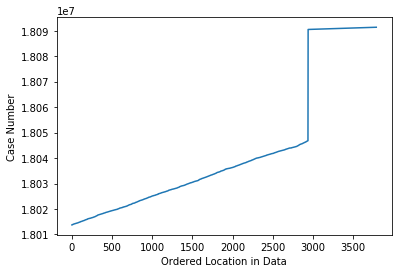

In [49]:
calls['CASENO'].sort_values().reset_index(drop=True).plot()
plt.xlabel("Ordered Location in Data")
plt.ylabel("Case Number")

I like to use interactive plotting tools so I can hover the mouse over the plot and read the values.  The cufflinks library adds plotly support to Pandas.  

In [50]:
calls['CASENO'].sort_values().reset_index(drop=True).iplot(
    layout = dict(yaxis=dict(title="Case Number", hoverformat="d"), 
                  xaxis=dict(title="Ordered Location in Data")))

Examining the distribution of case numbers shows a similar pattern

In [51]:
calls['CASENO'].iplot(kind="hist",bins=100);

### What might we be observing?

One possible explanation is that case numbers were assigned consecutively and then sampled uniformly at different rates for two different periods.  We will be able to understand this better by looking at the dates on the cases.

---
<br/><br/><br/>

## Examining the Date

Given the weird behavior with the case numbers let's dig into the date in which events were recorded.  Notice in this data we have several pieces of date/time information (this is not uncommon):
1. **`EVENTDT`**: This contains the date the event took place.  While it has time information the time appears to be `00:00:00`.  
1. **`EVENTTM`**: This contains the time at which the event took place.
1. **`InDbDate`**: This appears to be the date at which the data was entered in the database.  

In [52]:
calls.head(3)

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   

             CVLEGEND  CVDOW                InDbDate  \
0  DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1             LARCENY      3  09/06/2018 03:30:13 AM   
2             LARCENY      5  09/06/2018 03:30:09 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   

                     BLKADDR      City State        Day        Lat  \
0  OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  37.856572   
1         200 UNIVERSITY AVE  Berkeley    CA  Wednesday  37.865511   
2             2200 MILVIA ST  Berkeley    CA     Friday  37.868574   

           Lon  
0  -122.275241  
1  -122.309967  
2  -122.270415

When Pandas loads more complex fields like dates it will often load them as strings:

In [53]:
calls["EVENTDT"][0]

'04/18/2018 12:00:00 AM'

We will want to convert these to dates.  Pandas has a fairly sophisticated function `pd.to_datetime` which is capable of guessing reasonable conversions of dates to date objects. 

In [54]:
dates = pd.to_datetime(calls["EVENTDT"])
dates[0]

Timestamp('2018-04-18 00:00:00')

We can verify that the translations worked by looking at a few dates:

In [55]:
pd.DataFrame(dict(transformed=dates, original=calls["EVENTDT"])).head()

transformed                original
0  2018-04-18  04/18/2018 12:00:00 AM
1  2018-05-09  05/09/2018 12:00:00 AM
2  2018-05-18  05/18/2018 12:00:00 AM
3  2018-03-13  03/13/2018 12:00:00 AM
4  2018-03-31  03/31/2018 12:00:00 AM

We can also extract the time field:

In [56]:
times = pd.to_datetime(calls["EVENTTM"]).dt.time
times.head()

0    22:17:00
1    21:25:00
2    20:00:00
3    08:50:00
4    13:29:00
Name: EVENTTM, dtype: object

To combine the correct date and correct time field we use the built-in python datetime combine function.

In [57]:
from datetime import datetime
timestamps = pd.to_datetime(pd.concat([dates, times], axis=1).apply(
    lambda r: datetime.combine(r['EVENTDT'], r['EVENTTM']), axis=1))
timestamps.head()

0   2018-04-18 22:17:00
1   2018-05-09 21:25:00
2   2018-05-18 20:00:00
3   2018-03-13 08:50:00
4   2018-03-31 13:29:00
dtype: datetime64[ns]

We now updated calls to contain this additional informations:

In [58]:
calls['timestamp'] = timestamps
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State        Day        Lat  \
0     OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  37.856572   
1            200 UNIVERSITY AVE  Berkeley    CA  Wednesday  37.865511   
2                2200 MILVIA ST  Berkeley    CA     Friday  37.868574   
3                 1200 SIXTH ST  Berkeley    CA    Tuesday  37.881142   
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA   Saturday  37.870308   

           Lon           timestamp  
0  -122.275241 2018-04-18 22:17:00  
1  -122.309967 2018-05-09 21:25:00  
2  -122.270415 2018-05-18 20:00:00  
3   -122.30191 2018-03-13 08:50:00  
4   -122.26805 2018-03-31 13:29:00

### What time range does the data represent

In [59]:
calls['timestamp'].min()

Timestamp('2018-03-08 00:00:00')

In [60]:
calls['timestamp'].max()

Timestamp('2018-08-19 22:25:00')

---
<br/><br/><br/>

### Back to the Case Numbers

In [61]:
(
    calls
        .sort_values('timestamp')
        .iplot(
            mode='markers', size=5,
            x='timestamp', y='CASENO',
            layout = dict(yaxis=dict(title="Case Number", hoverformat="d"), 
                  xaxis=dict(title="Date of Call")))
)

#### Explanation?

Perhaps there are multiple different record books with different numbering schemes?  This might be something worth investigating further.

### A Negative Result...

In the above analysis of case numbers all we can really conclude is that we don't understand how this variable was created.  The patterns in the values suggest that there may be some sampling and it is possibly worth contacting the data provider to learn more.

---
<br/><br/><br/>


### Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [62]:
dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
calls.groupby('Day')['CASENO'].count()[dow].iplot(kind='bar', yTitle="Count")

### How about temporal patterns within a day?

In [63]:
ts = calls['timestamp']
minute_of_day = ts.dt.hour * 60 + ts.dt.minute
hour_of_day = minute_of_day / 60.

calls['minute_of_day'] = minute_of_day
calls['hour_of_day'] = hour_of_day


In [64]:
py.iplot(ff.create_distplot([hour_of_day],group_labels=["Hour"],bin_size=1))

### Observations?

In the above plot we see the standard pattern of limited activity early in the morning around here 6:00AM.

---
<br/><br/><br/>

### Smoothing Parameters

In the above plot we see a smoothed curve approximating the histogram.  This is an example of a kernel density estimator (KDE).  The KDE, like the histogram, has a parameter that determines it's smoothness.  Many packages (Plotly and Seaborn) use a boostrap like procedure to choose the best value.  

To understand how this parameter works we will use seaborn which let's you also set the parameter manually.  

/Users/fperez/usr/conda/envs/data100/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



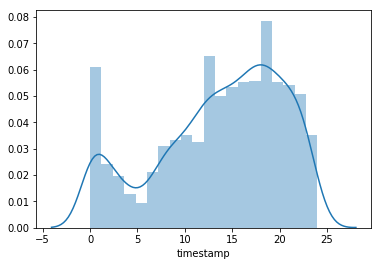

In [65]:
sns.distplot(hour_of_day, rug=False)

Notice in the above plot that the interpolation tries to follow the histogram to closely. 

### Stratified Analysis

To better understand the time of day a report occurs we could stratify the analysis by the day of the week.  To do this we will use box plots.  


In [66]:
## Using Pandas built in box plot
# calls['hour_of_day'] = minute_in_day
# calls.boxplot('hour_of_day', by='Day')

In [67]:
groups = calls.groupby("Day")
boxes = {i: go.Box(y=df["hour_of_day"], name=i) for (i, df) in groups}
py.iplot([boxes[d] for d in dow])

In [68]:
py.iplot(ff.create_violin(calls, data_header='hour_of_day', group_header="Day"))

#### Observations?

There are no very clear patterns here.  It is possible Fridays might have crimes shifted slightly more to the evening.  In general the time a crime is reported seems fairly consistent throughout the week.

---
<br/><br/><br/>

### Examining the Event

We also have data about the different kinds of crimes being reported

In [69]:
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  18022300               DISTURBANCE  04/18/2018 12:00:00 AM   22:17   
1  18026683  THEFT MISD. (UNDER $950)  05/09/2018 12:00:00 AM   21:25   
2  18038550  THEFT MISD. (UNDER $950)  05/18/2018 12:00:00 AM   20:00   
3  18014810             BURGLARY AUTO  03/13/2018 12:00:00 AM   08:50   
4  18018643           ALCOHOL OFFENSE  03/31/2018 12:00:00 AM   13:29   

               CVLEGEND  CVDOW                InDbDate  \
0    DISORDERLY CONDUCT      3  09/06/2018 03:30:12 AM   
1               LARCENY      3  09/06/2018 03:30:13 AM   
2               LARCENY      5  09/06/2018 03:30:09 AM   
3    BURGLARY - VEHICLE      2  09/06/2018 03:30:08 AM   
4  LIQUOR LAW VIOLATION      6  09/06/2018 03:30:11 AM   

                                      Block_Location  \
0  OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...   
1  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...   
3  1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....   
4  CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...   

                        BLKADDR      City State        Day        Lat  \
0     OREGON STREET & MCGEE AVE  Berkeley    CA  Wednesday  37.856572   
1            200 UNIVERSITY AVE  Berkeley    CA  Wednesday  37.865511   
2                2200 MILVIA ST  Berkeley    CA     Friday  37.868574   
3                 1200 SIXTH ST  Berkeley    CA    Tuesday  37.881142   
4  CENTER STREET & SHATTUCK AVE  Berkeley    CA   Saturday  37.870308   

           Lon           timestamp  minute_of_day  hour_of_day  
0  -122.275241 2018-04-18 22:17:00           1337    22.283333  
1  -122.309967 2018-05-09 21:25:00           1285    21.416667  
2  -122.270415 2018-05-18 20:00:00           1200    20.000000  
3   -122.30191 2018-03-13 08:50:00            530     8.833333  
4   -122.26805 2018-03-31 13:29:00            809    13.483333

### The Offense Field

The Offense field appears to contain the specific crime being reported.  As nominal data we might want to see a summary constructed by computing counts of each offense type:

In [70]:
calls['OFFENSE'].value_counts(dropna=False).iplot(kind="bar")

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

---
<br/><br/><br/>

### CVLEGEND

The CVLEGEND filed provides the broad category of crime and is a good mechanism to group potentially similar crimes. 

In [71]:
calls['CVLEGEND'].value_counts(dropna=False).iplot(kind="bar")

Notice that when we group by the crime time we see that **larceny** becomes the dominant category.  Larceny is essentially stealing -- taking someone else stuff without force.

### Stratified Analysis of Time of Day by CVLEGEND

View the crime time periods broken down by crime type:

In [72]:
boxes = [(len(df), go.Box(y=df["hour_of_day"], name=i)) for (i, df) in calls.groupby("CVLEGEND")]
py.iplot([r[1] for r in sorted(boxes, key=lambda x:x[0], reverse=True)])

In [73]:
py.iplot(ff.create_distplot([
    calls[calls['CVLEGEND'] == "NOISE VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "DRUG VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "LIQUOR LAW VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "FRAUD"]['hour_of_day']
],
    group_labels=["Noise Violation", "Drug Violation", "Liquor Violation", "Fraud"], 
    ))


## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

In [74]:
missing_lat_lon = calls[calls[['Lat', 'Lon']].isnull().any(axis=1)]
missing_lat_lon['CVLEGEND'].value_counts().iplot(kind="bar")

### Observations?

There is a clear bias towards drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

We might further normalize the analysis by the frequency to find which type of crime has the highest proportion of missing values.

In [75]:
(
    missing_lat_lon['CVLEGEND'].value_counts() / calls['CVLEGEND'].value_counts()
).sort_values(ascending=False).iplot(kind="bar")

---
<br/><br/><br/> 

### Day of Year and Missing Values:

We might also want to examine the time of day in which latitude and longitude are missing:

In [76]:
ts = calls['timestamp']

py.iplot(ff.create_distplot([calls['timestamp'].dt.dayofyear, 
                             missing_lat_lon['timestamp'].dt.dayofyear],
                            group_labels=["all data", "missing lat-lon"],bin_size=2))

### Observations?

Pretty similar 

In [77]:
#!pip install --upgrade folium
import folium
print(folium.__version__, "should be at least 0.3.0")

0.6.0 should be at least 0.3.0


In [78]:
import folium
import folium.plugins # The Folium Javascript Map Library

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls[['Lat', 'Lon']].astype('float').dropna().as_matrix()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

/Users/fperez/usr/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



### Questions

1. Is campus really the safest place to be?
1. Why are all the calls located on the street and at often at intersections?


In [79]:
cluster = folium.plugins.MarkerCluster()
for _, r in calls[['Lat', 'Lon', 'CVLEGEND']].tail(1000).dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Lon"])], popup=r['CVLEGEND']))
    
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
sf_map.add_child(cluster)
sf_map